# Imports

In [1]:
import os
import errno

import pandas as pd
import numpy as np

from helper_functions import (variables_amount_deviation, perform_feauture_selection, 
                              cross_validation_framework, plotting_outlier, transcation_report)

from sklearn.preprocessing import MinMaxScaler

from pyod.models import hbos, mcd, lof, iforest, cblof, knn, abod, ocsvm, pca, copod, loda, xgbod

# Data Loading and Preprocessing

In [45]:
# df = pd.read_csv('data/sim0.csv', delimiter=';', low_memory=False)
df = pd.read_csv('data/sim1.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim3.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim4.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim5.csv', delimiter=';', low_memory=False)


# Strip hour since all are the same
df['date'] = pd.to_datetime(df.date).dt.date

# Drop columns with unique values
df.drop(columns=['currency', 'location'], inplace=True)

df.head()

,account_from,account_to,sender,receiver,amount,channel,date,flag,transaction_type,transaction_id
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,2021-01-01,transaction,2.2,35655
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,2021-01-01,transaction,2.2,35656
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,2021-01-01,transaction,0.1,35657
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,2021-01-01,fraud,bribe,35658
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,2021-01-01,transaction,0.2,35659


In [46]:
# Add type of transaction markers (B2B-P2P-B2P-P2B)

# Create markers
p2p_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('individual'))
p2b_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('business'))
b2b_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('business'))
b2p_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('individual'))

# Create Series object and add it to dataframe
transaction_mode = pd.Series(['']*df.shape[0])
transaction_mode[p2p_marker] = 'P2P'
transaction_mode[p2b_marker] = 'P2B'
transaction_mode[b2b_marker] = 'B2B'
transaction_mode[b2p_marker] = 'B2P'
df['transaction_mode'] = transaction_mode

# Add Sender and Receiver Marker
df['sender_type'] = df.transaction_mode.astype(str).str[0]
df['receiver_type'] = df.transaction_mode.astype(str).str[2]

# Manipulate date 
df['day_of_week'] = pd.to_datetime(df.date).dt.dayofweek
df['month'] = pd.to_datetime(df.date).dt.month
df.drop(columns=['date'], inplace=True)

# Transform amount using logarithm
# df['amount'] = df.amount.transform(np.log)

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,sender_type,receiver_type,day_of_week,month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,B,B,4,1
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,B,B,4,1
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,B,B,4,1
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,B,P,4,1
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,P,P,4,1


In [47]:
# Get indicators of sender and receiver for both the deviation of the transaction
# According to certain groups

df = variables_amount_deviation(df, ['month'], ['sender_monthly', 'receiver_monthly'])
df = variables_amount_deviation(df, ['channel'], ['sender_medium', 'receiver_medium'])
df = variables_amount_deviation(df, ['account_from'], ['sender_account_from', 'receiver_account_from'])
df = variables_amount_deviation(df, ['account_to'], ['sender_account_to', 'receiver_account_to'])
df = variables_amount_deviation(df, ['channel', 'month'], ['sender_medium_month', 'receiver_medium_month'])
df = variables_amount_deviation(df, ['month', 'day_of_week'], ['sender_month_dayofweek', 'receiver_month_dayofweek'])
df = variables_amount_deviation(df, ['channel', 'day_of_week'], ['sender_medium_dayofweek', 'receiver_medium_dayofweek'])
df = variables_amount_deviation(df, ['account_from', 'channel'], ['sender_account_from_medium', 'receiver_account_from_medium'])
df = variables_amount_deviation(df, ['account_from', 'month'], ['sender_account_from_month', 'receiver_account_from_month'])
df = variables_amount_deviation(df, ['account_from', 'day_of_week'], ['sender_account_from_day_of_week', 
                                                                      'receiver_account_from_day_of_week'])
df = variables_amount_deviation(df, ['account_to', 'channel'], ['sender_fieldo_medium', 'receiver_fieldo_medium'])
df = variables_amount_deviation(df, ['account_to', 'month'], ['sender_fieldo_month', 'receiver_fieldo_month'])
df = variables_amount_deviation(df, ['account_to', 'day_of_week'], ['sender_fieldo_day_of_week', 'receiver_fieldo_day_of_week'])
# df = variables_amount_deviation(df, ['channel', 'month', 'day_of_week'], ['sender_medium_month_dayofweek',
#                                                                          'receiver_medium_month_dayofweek'])
# df = variables_amount_deviation(df, ['account_from', 'month', 'channel'], ['sender_account_from_month_medium', 
#                                                                           'receiver_account_from_month_medium'])
# df = variables_amount_deviation(df, ['account_from', 'month','day_of_week'], ['sender_account_from_month_day_of_week', 
#                                                                               'receiver_account_from_month_day_of_week'])
# df = variables_amount_deviation(df, ['account_from', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week', 
#                                                                                 'receiver_account_from_medium_day_of_week'])
# df = variables_amount_deviation(df, ['account_from', 'month', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week_month', 
#                                                                                          'sender_account_from_medium_day_of_week_month'])
# df = variables_amount_deviation(df, ['account_to', 'month', 'channel'], ['sender_account_to_month_medium', 
#                                                                     'receiver_account_to_month_medium'])
# df = variables_amount_deviation(df, ['account_to', 'month','day_of_week'], ['sender_account_to_month_day_of_week', 
#                                                                         'receiver_account_to_month_day_of_week'])
# df = variables_amount_deviation(df, ['account_to', 'channel', 'day_of_week'], ['sender_fieldo_medium_day_of_week', 
#                                                                           'receiver_fieldo_medium_day_of_week'])
# df = variables_amount_deviation(df, ['account_to', 'month', 'channel', 'day_of_week'], ['sender_account_to_medium_day_of_week_month', 
#                                                                                    'sender_account_to_medium_day_of_week_month'])

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_month,receiver_account_from_month,sender_account_from_day_of_week,receiver_account_from_day_of_week,sender_fieldo_medium,receiver_fieldo_medium,sender_fieldo_month,receiver_fieldo_month,sender_fieldo_day_of_week,receiver_fieldo_day_of_week
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,...,-9.597737,-11.969154,-13.227427,-18.135013,-17.938438,-15.687191,-15.377369,-13.349430,-18.893403,-18.399891
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,...,-68.997358,-84.418756,-92.842182,-125.626755,-120.741416,-122.707446,-107.958335,-93.566421,-130.743352,-126.959052
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,...,1.290603,1.311334,1.366480,1.568929,1.391109,1.381105,1.593330,1.354871,1.609427,1.499716
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,...,-1.174847,inf,-1.938023,inf,-313.777038,-313.777038,-0.002608,-80.044010,-0.880423,-40.709931
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,...,-3.193896,-3.215190,-1.979993,-2.268911,-3.494436,-2.134434,-2.948617,-3.032655,-2.847416,-2.587624


In [48]:
# Field A Scaling

# Segment types of senders
df_p = df[p2p_marker | p2b_marker]
df_b = df[b2p_marker | b2b_marker]

# Get Median 
median_p = np.median(df_p.amount)
median_b = np.median(df_b.amount)

# Median Deviation 
median_desviation_p = df_p.amount.sub(median_p)
median_desviation_b = df_b.amount.sub(median_b)

# Median Absolute Deviation
abs_median_desviation_p = np.median(median_desviation_p.abs())
abs_median_desviation_b = np.median(median_desviation_b.abs())

# Scaling 
df_p_scaled = median_desviation_p/abs_median_desviation_p
df_b_scaled = median_desviation_b/abs_median_desviation_b

# Assign values
df.loc[(p2p_marker | p2b_marker), 'amount'] = df_p_scaled
df.loc[(b2p_marker | b2b_marker), 'amount'] = df_b_scaled

df = df.replace([np.inf, -np.inf, np.nan], 0)
df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_month,receiver_account_from_month,sender_account_from_day_of_week,receiver_account_from_day_of_week,sender_fieldo_medium,receiver_fieldo_medium,sender_fieldo_month,receiver_fieldo_month,sender_fieldo_day_of_week,receiver_fieldo_day_of_week
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,15.353341,Paym,transaction,2.2,35655,B2B,...,-9.597737,-11.969154,-13.227427,-18.135013,-17.938438,-15.687191,-15.377369,-13.349430,-18.893403,-18.399891
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,106.878088,LINK,transaction,2.2,35656,B2B,...,-68.997358,-84.418756,-92.842182,-125.626755,-120.741416,-122.707446,-107.958335,-93.566421,-130.743352,-126.959052
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,-1.423746,C&CCC,transaction,0.1,35657,B2B,...,1.290603,1.311334,1.366480,1.568929,1.391109,1.381105,1.593330,1.354871,1.609427,1.499716
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2.375095,CASH,fraud,bribe,35658,B2P,...,-1.174847,0.000000,-1.938023,0.000000,-313.777038,-313.777038,-0.002608,-80.044010,-0.880423,-40.709931
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,2.821119,FPS,transaction,0.2,35659,P2P,...,-3.193896,-3.215190,-1.979993,-2.268911,-3.494436,-2.134434,-2.948617,-3.032655,-2.847416,-2.587624


In [49]:
df.columns

Index(['account_from', 'account_to', 'sender', 'receiver', 'amount', 'channel',
       'flag', 'transaction_type', 'transaction_id', 'transaction_mode',
       'sender_type', 'receiver_type', 'day_of_week', 'month',
       'sender_monthly', 'receiver_monthly', 'sender_medium',
       'receiver_medium', 'sender_account_from', 'receiver_account_from',
       'sender_account_to', 'receiver_account_to', 'sender_medium_month',
       'receiver_medium_month', 'sender_month_dayofweek',
       'receiver_month_dayofweek', 'sender_medium_dayofweek',
       'receiver_medium_dayofweek', 'sender_account_from_medium',
       'receiver_account_from_medium', 'sender_account_from_month',
       'receiver_account_from_month', 'sender_account_from_day_of_week',
       'receiver_account_from_day_of_week', 'sender_fieldo_medium',
       'receiver_fieldo_medium', 'sender_fieldo_month',
       'receiver_fieldo_month', 'sender_fieldo_day_of_week',
       'receiver_fieldo_day_of_week'],
      dtype='object')

In [50]:
df_trans = df.copy()
scaler = MinMaxScaler()

fraud_transactions = df[df["flag"] == "fraud"]
n_frauds = fraud_transactions.shape[0]

# Fraud amount
amount_dict = fraud_transactions.groupby("amount").amount.count().to_dict()
fraud_amount_keys = list(amount_dict.keys())
series_amount = np.array([0 if i not in fraud_amount_keys else amount_dict[i] for i in df["amount"]])
df_trans["fraud_amount"] = scaler.fit_transform(series_amount.reshape(-1, 1))

# Channel fraud
channel_fraud_dict = fraud_transactions.groupby("channel").channel.count().to_dict()
channel_dict = df.groupby("channel").channel.count().to_dict()
fraud_channel_keys = list(channel_fraud_dict.keys())
df_trans["fraud_channel"] = pd.Series([channel_fraud_dict[i]/channel_dict[i] if i in fraud_channel_keys else 0 for i in df["channel"]])

# Day fraud
day_df = fraud_transactions.groupby("day_of_week").day_of_week.count()/n_frauds
day_dict = day_df.to_dict()
fraud_day_keys = list(day_dict.keys())
df_trans["fraud_weekday"] = pd.Series([day_dict[i] if i in fraud_day_keys else 0 for i in df["day_of_week"]])

df_trans.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,receiver_account_from_day_of_week,sender_fieldo_medium,receiver_fieldo_medium,sender_fieldo_month,receiver_fieldo_month,sender_fieldo_day_of_week,receiver_fieldo_day_of_week,fraud_amount,fraud_channel,fraud_weekday
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,15.353341,Paym,transaction,2.2,35655,B2B,...,-18.135013,-17.938438,-15.687191,-15.377369,-13.349430,-18.893403,-18.399891,0.000000,0.012663,0.815217
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,106.878088,LINK,transaction,2.2,35656,B2B,...,-125.626755,-120.741416,-122.707446,-107.958335,-93.566421,-130.743352,-126.959052,0.000000,0.013573,0.815217
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,-1.423746,C&CCC,transaction,0.1,35657,B2B,...,1.568929,1.391109,1.381105,1.593330,1.354871,1.609427,1.499716,0.000000,0.013887,0.815217
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2.375095,CASH,fraud,bribe,35658,B2P,...,0.000000,-313.777038,-313.777038,-0.002608,-80.044010,-0.880423,-40.709931,0.047619,0.947059,0.815217
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,2.821119,FPS,transaction,0.2,35659,P2P,...,-2.268911,-3.494436,-2.134434,-2.948617,-3.032655,-2.847416,-2.587624,0.000000,0.011796,0.815217


# Feature Selection

In [51]:
df_numerical = df.select_dtypes('float64')

df_trans_numerical = df_trans.select_dtypes('float64')
df_numerical.columns

Index(['amount', 'sender_monthly', 'receiver_monthly', 'sender_medium',
       'receiver_medium', 'sender_account_from', 'receiver_account_from',
       'sender_account_to', 'receiver_account_to', 'sender_medium_month',
       'receiver_medium_month', 'sender_month_dayofweek',
       'receiver_month_dayofweek', 'sender_medium_dayofweek',
       'receiver_medium_dayofweek', 'sender_account_from_medium',
       'receiver_account_from_medium', 'sender_account_from_month',
       'receiver_account_from_month', 'sender_account_from_day_of_week',
       'receiver_account_from_day_of_week', 'sender_fieldo_medium',
       'receiver_fieldo_medium', 'sender_fieldo_month',
       'receiver_fieldo_month', 'sender_fieldo_day_of_week',
       'receiver_fieldo_day_of_week'],
      dtype='object')

In [52]:
# df_feature_selection = perform_feauture_selection(df_numerical)

# df_feature_selection.head()

In [53]:
df_trans_feature_selection = perform_feauture_selection(df_trans_numerical)

df_trans_feature_selection.head()

,fraud_weekday,fraud_channel,sender_account_from_month,sender_account_from_day_of_week,sender_account_from_medium,sender_account_from,fraud_amount,receiver_account_from_medium,receiver_account_from_month,receiver_account_from_day_of_week,receiver_month_dayofweek,sender_fieldo_month,sender_fieldo_medium,sender_month_dayofweek,sender_account_to,sender_fieldo_day_of_week,receiver_account_from,receiver_medium_dayofweek
0,0.815217,0.012663,-9.597737,-13.227427,-11.782456,-14.689864,0.000000,-12.687862,-11.969154,-18.135013,-24.903818,-15.377369,-17.938438,-7.248907,-17.787941,-18.893403,-17.140438,-18.407777
1,0.815217,0.013573,-68.997358,-92.842182,-89.087636,-102.620567,0.000000,-115.676076,-84.418756,-125.626755,-169.048857,-107.958335,-120.741416,-53.138207,-123.024314,-130.743352,-118.950005,-151.098590
2,0.815217,0.013887,1.290603,1.366480,1.496006,1.428411,0.000000,1.403420,1.311334,1.568929,1.518914,1.593330,1.391109,1.162903,1.502577,1.609427,1.521924,1.282630
3,0.815217,0.947059,-1.174847,-1.938023,-313.777038,-2.221255,0.047619,-313.777038,0.000000,0.000000,-21.825857,-0.002608,-313.777038,-0.741785,-0.554187,-0.880423,0.000000,-138.324649
4,0.815217,0.011796,-3.193896,-1.979993,-1.397853,-2.572842,0.000000,-1.697315,-3.215190,-2.268911,0.101086,-2.948617,-3.494436,-2.624242,-2.842383,-2.847416,-2.522378,-1.136685


In [54]:
df_trans_feature_selection.columns

Index(['fraud_weekday', 'fraud_channel', 'sender_account_from_month',
       'sender_account_from_day_of_week', 'sender_account_from_medium',
       'sender_account_from', 'fraud_amount', 'receiver_account_from_medium',
       'receiver_account_from_month', 'receiver_account_from_day_of_week',
       'receiver_month_dayofweek', 'sender_fieldo_month',
       'sender_fieldo_medium', 'sender_month_dayofweek', 'sender_account_to',
       'sender_fieldo_day_of_week', 'receiver_account_from',
       'receiver_medium_dayofweek'],
      dtype='object')

# Experimentation


In [64]:
# Create Directory
root = 'experiments/'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

Directory already exist
Type Experiment Name: simple_comb_ensemblex3_3_extra_layer


## Define experiment parameters

In [27]:
# pca_od = pca.PCA(contamination=CONTAMINATION, n_components=3)
# lof_od = lof.LOF(contamination=CONTAMINATION)
# cblof_od = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=7)
# copod_od = copod.COPOD(contamination=CONTAMINATION, n_jobs=-1)
# mcd_od = mcd.MCD(contamination=CONTAMINATION, assume_centered=True, support_fraction=0.6)
# hbos_od = hbos.HBOS(contamination=CONTAMINATION, n_bins=6)
# abod_od = abod.ABOD(contamination=CONTAMINATION, method='fast', n_neighbors=3)
# knn_od = knn.KNN(contamination=CONTAMINATION, n_neighbors=5, n_jobs=-1)
# loda_od = loda.LODA(contamination=CONTAMINATION)

In [28]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()

In [65]:
# Define Dictionary of Representation Learners
CONTAMINATION = 0.01

pca_od1 = pca.PCA(contamination=CONTAMINATION, n_components=3)
pca_od2 = pca.PCA(contamination=CONTAMINATION, n_components=7)
pca_od3 = pca.PCA(contamination=CONTAMINATION, n_components=5)
knn_od1 = knn.KNN(contamination=CONTAMINATION, n_neighbors=3, n_jobs=-1)
knn_od2 = knn.KNN(contamination=CONTAMINATION, n_neighbors=6, n_jobs=-1)
knn_od3 = knn.KNN(contamination=CONTAMINATION, n_neighbors=9, n_jobs=-1)
cblof_od1 = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=4)
cblof_od2 = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=2)
cblof_od3 = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=6)

representation_learning_model_dict = {'PCA1': pca_od1,
                                      'PCA2': pca_od2,
                                      'PCA3': pca_od3,
                                      'KNN1': knn_od1,
                                      'KNN2': knn_od2,
                                      'KNN3': knn_od3,
                                      'CBLOF1': cblof_od1,
                                      'CBLOF2': cblof_od2,
                                      'CBLOF3': cblof_od3}
rep_learner_codes = 'PCAx3_KNNx3_CBLOFx3'

# Define Meta-Learner
metalearner = iforest.IForest(contamination=CONTAMINATION, n_estimators=200, 
                        bootstrap=True, n_jobs=-1, behaviour='new')
metalearner_name = 'Isolation_Forest_3_layers'

# Define Datasets
X = df_trans_feature_selection
y = pd.get_dummies(df.flag).fraud

# Define Threshold
THRESHOLD = 1 - CONTAMINATION

# Define number of splits of Cross Validation
k = 5

# Define accuracy evabluation metric
accuracy = 'auc' # 'f1' or 'precision' or 'auc' or 'recall' auc is area under the precision recall curve

# Number of Stacking Layers
n_layers = 3

1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


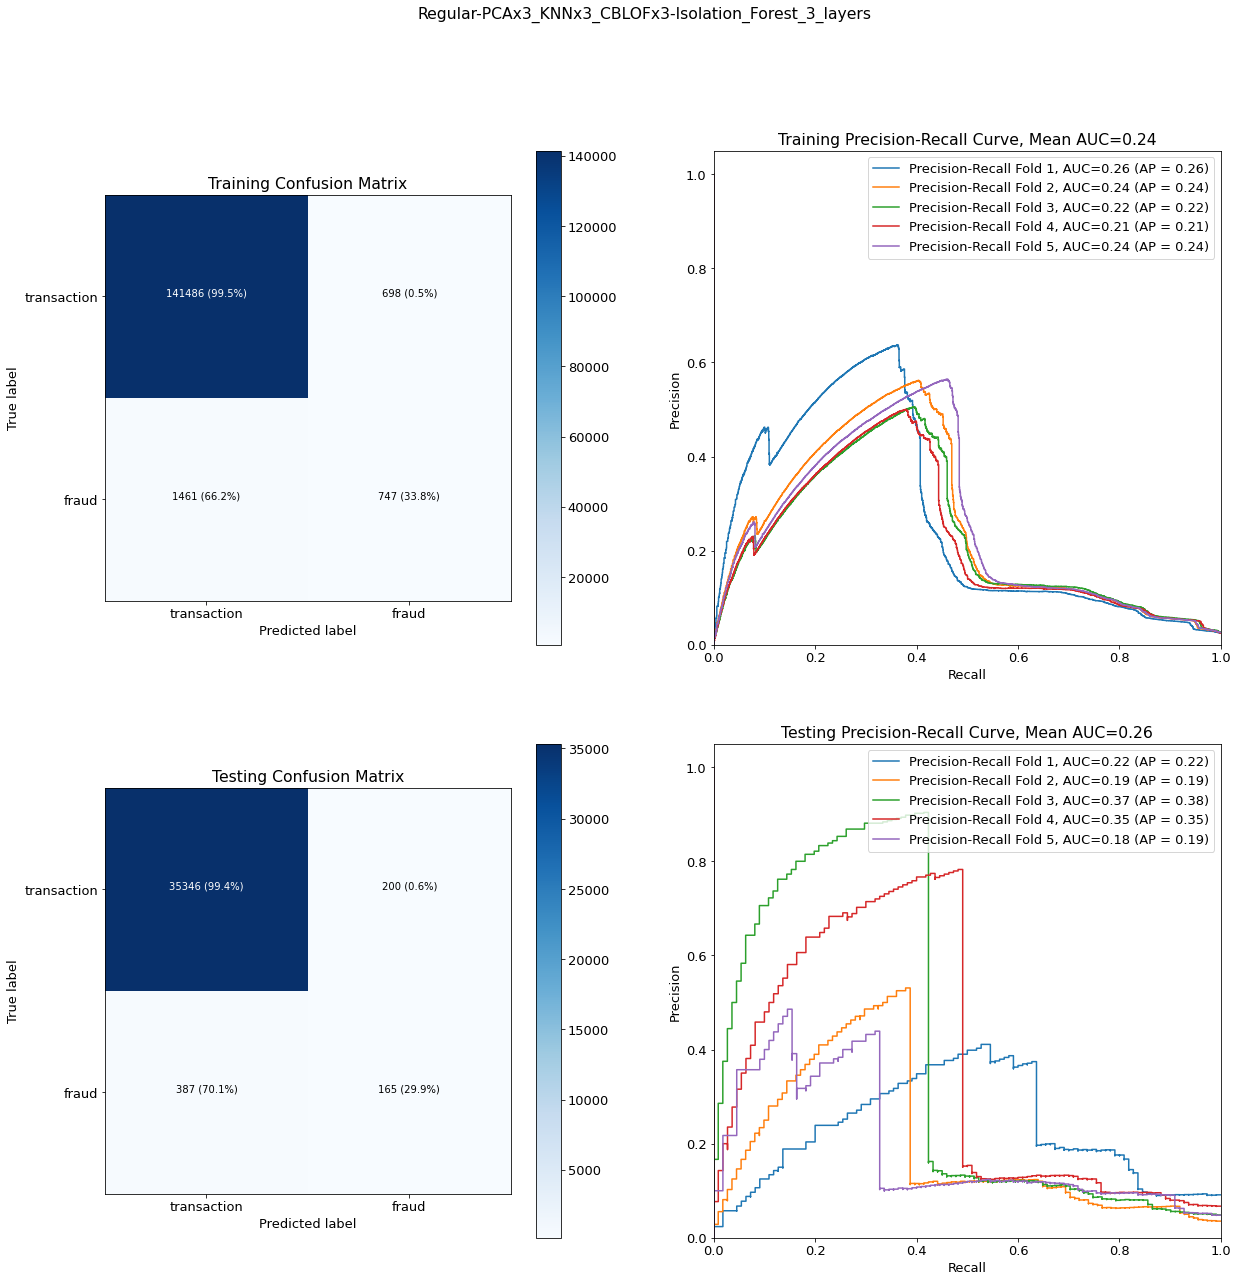

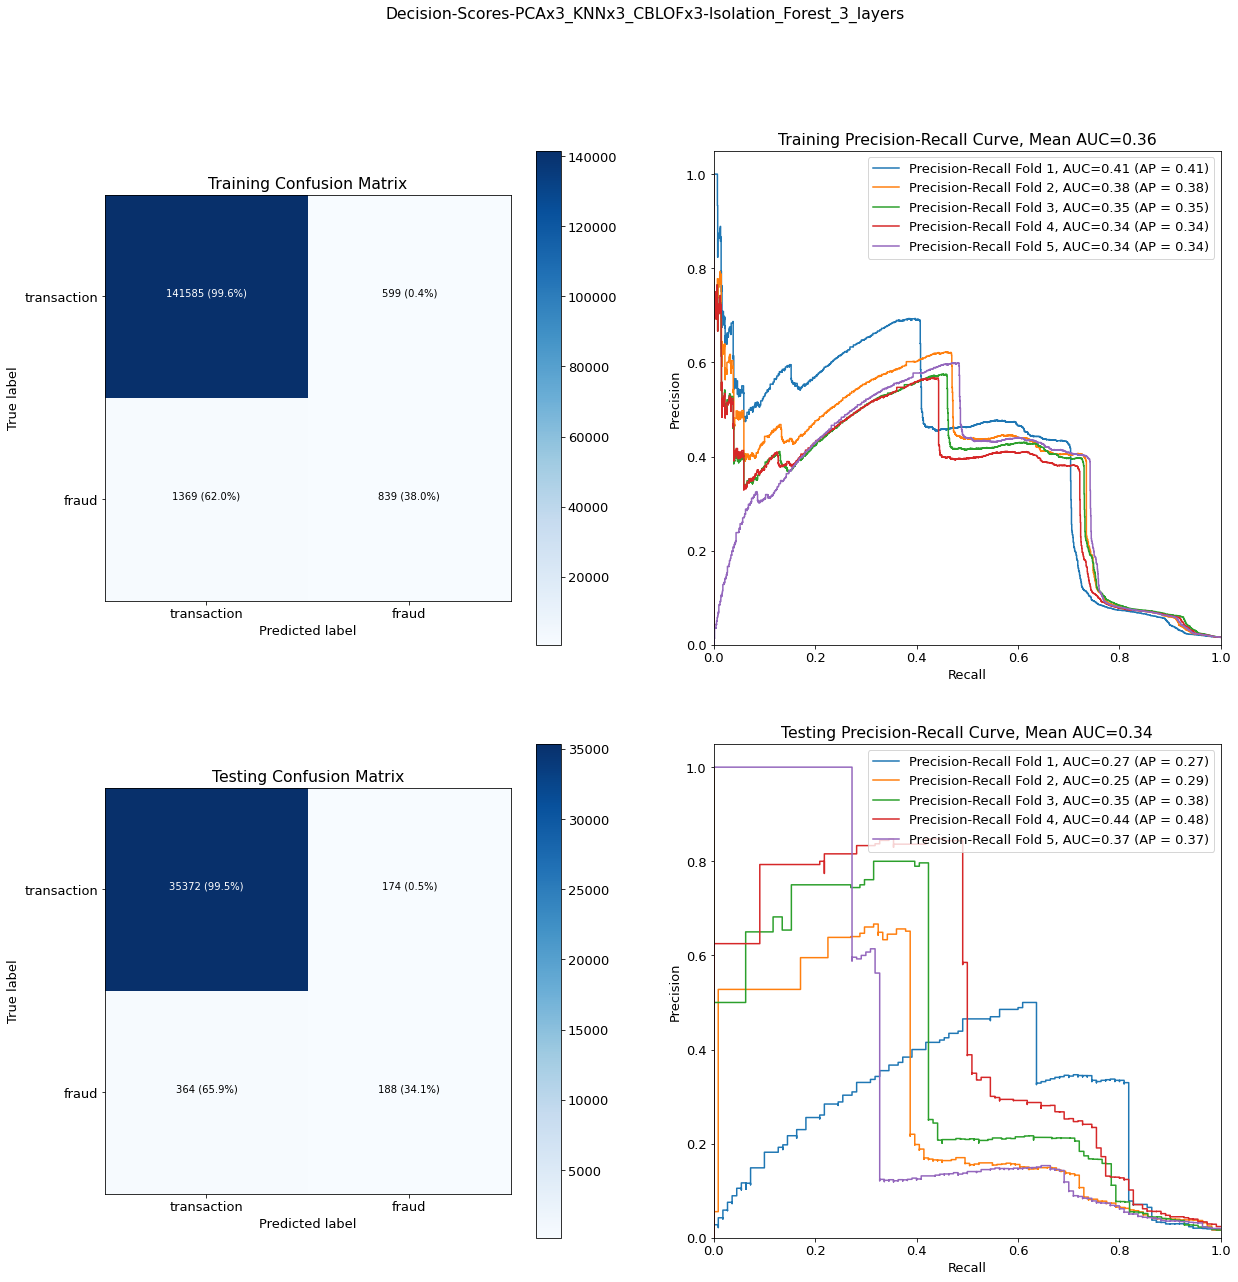

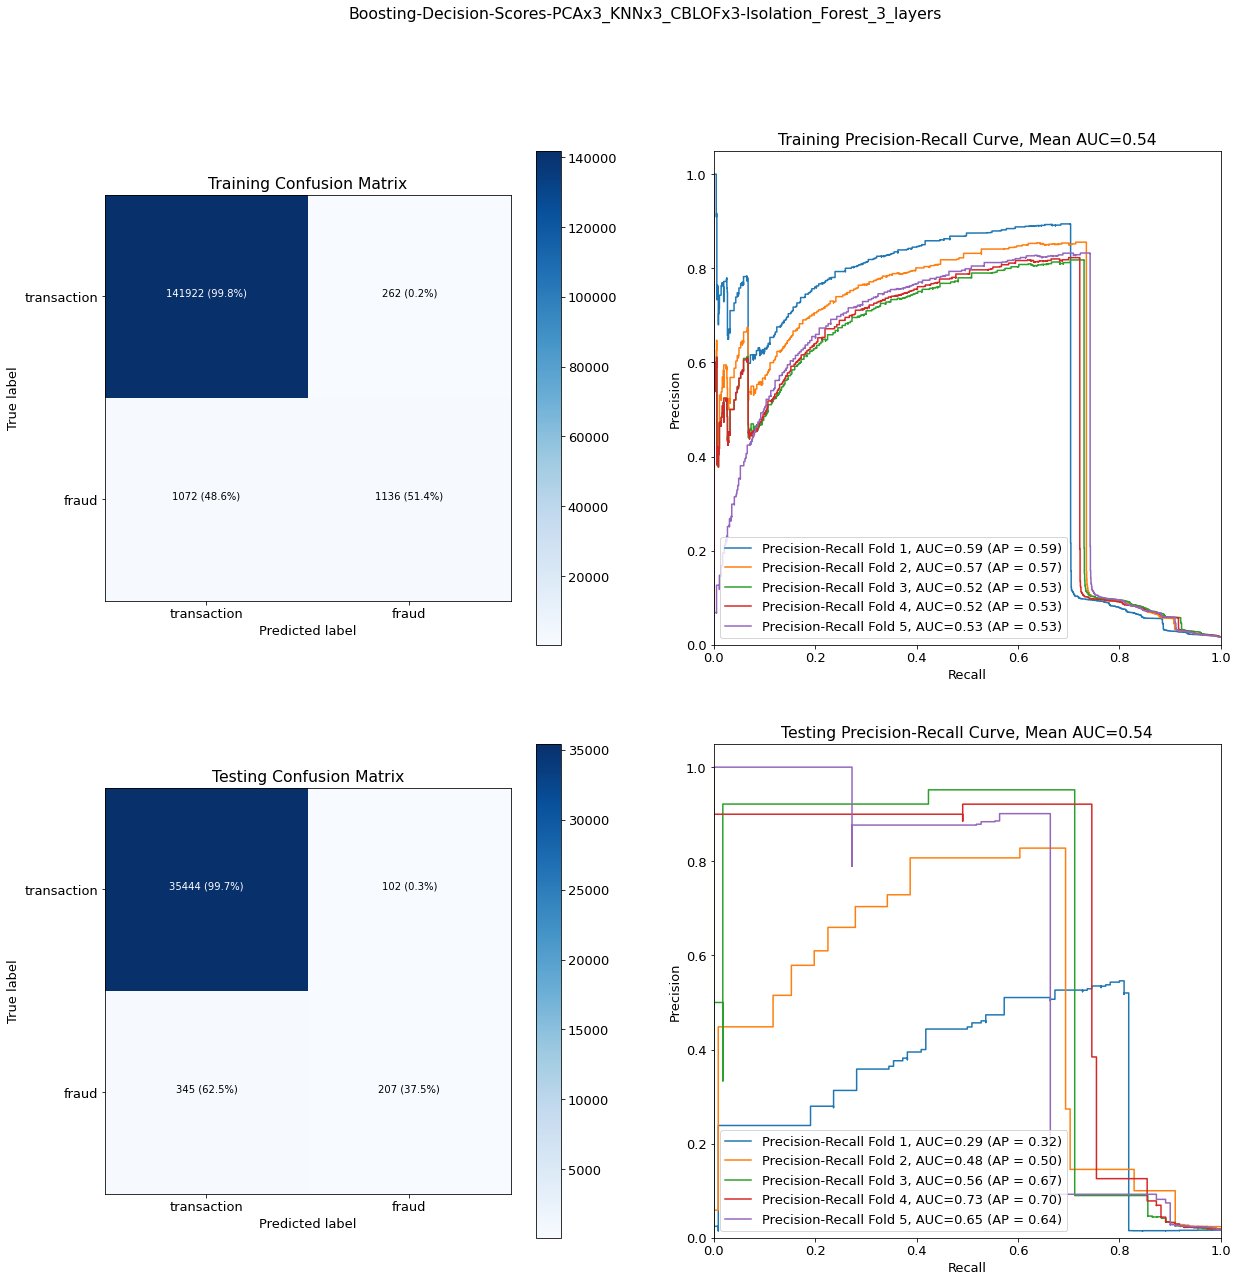

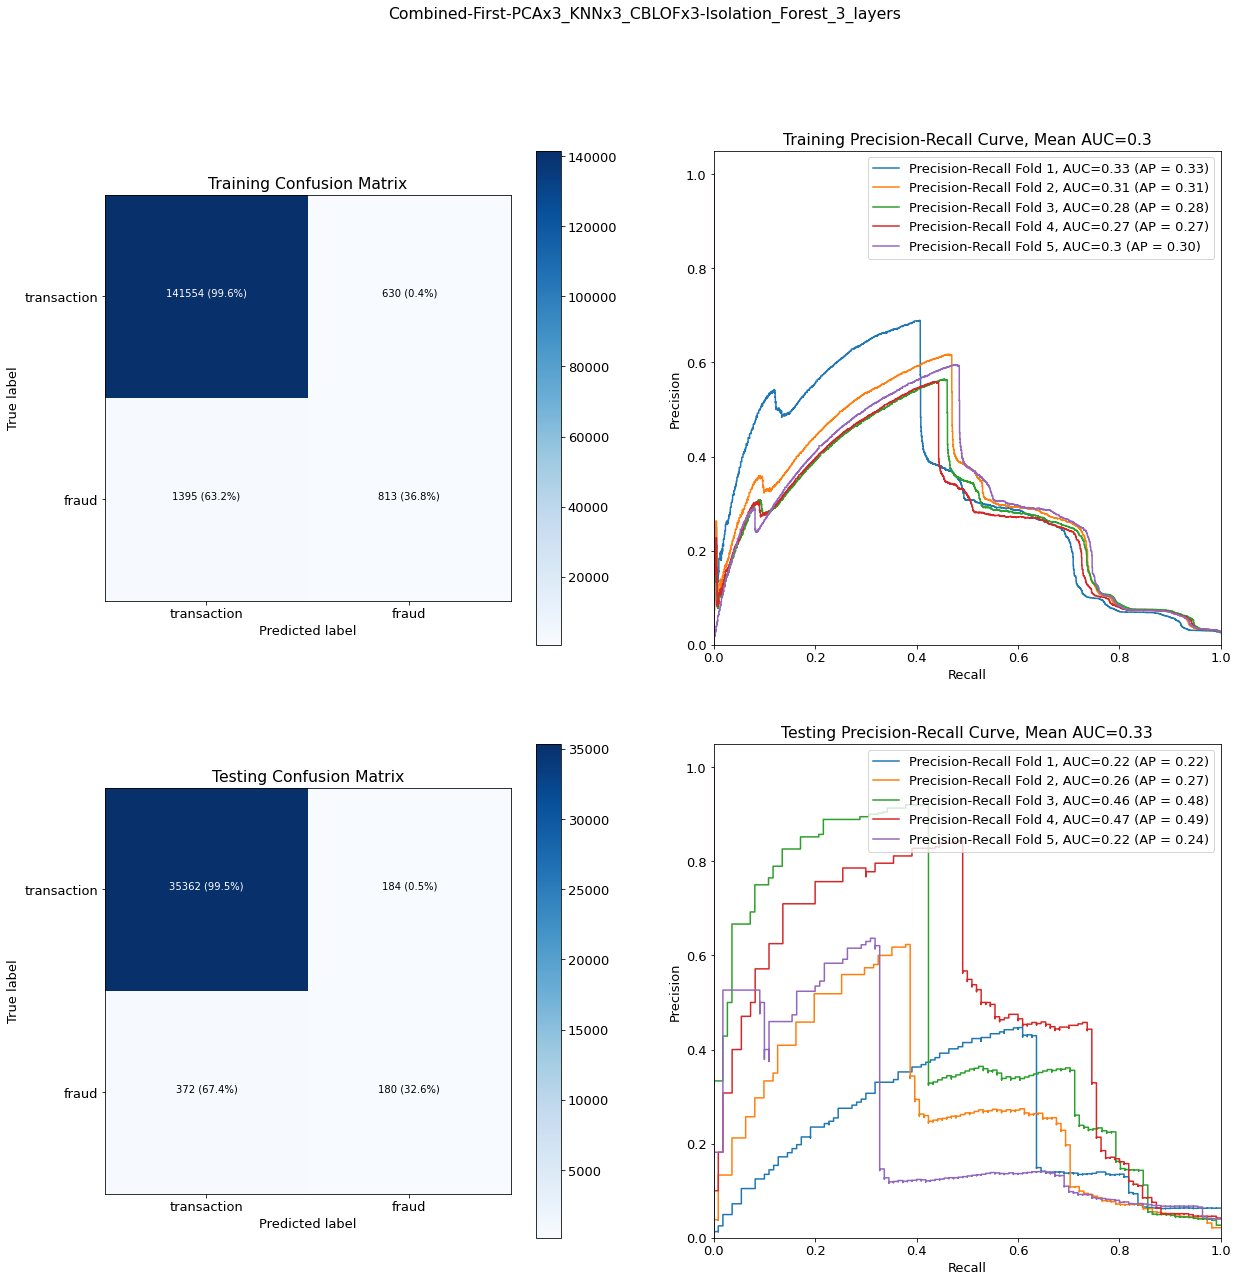

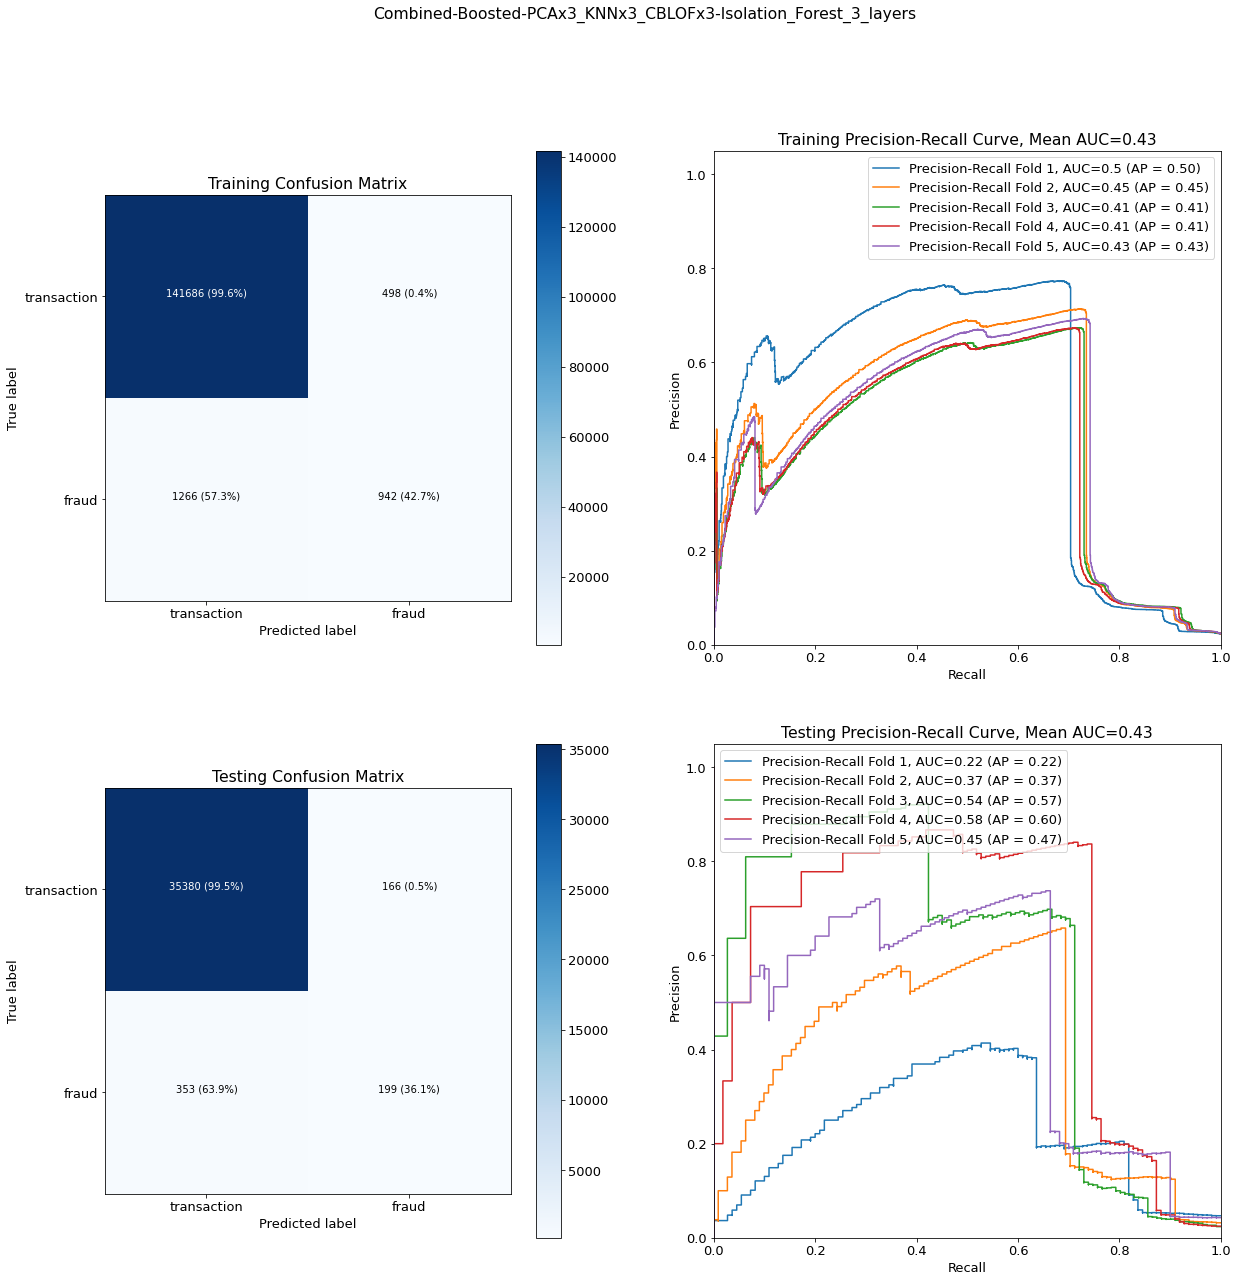

In [66]:
# Call the function
training_results, testing_results = cross_validation_framework(metalearner, X, y, k, metalearner_name=metalearner_name, 
                                                               threshold=THRESHOLD, accuracy=accuracy, supervised=False,
                                                               representation_learning_model_dict=representation_learning_model_dict,
                                                               rep_learner_codes=rep_learner_codes, mode='stacking', n_layers=n_layers, path=path)

1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


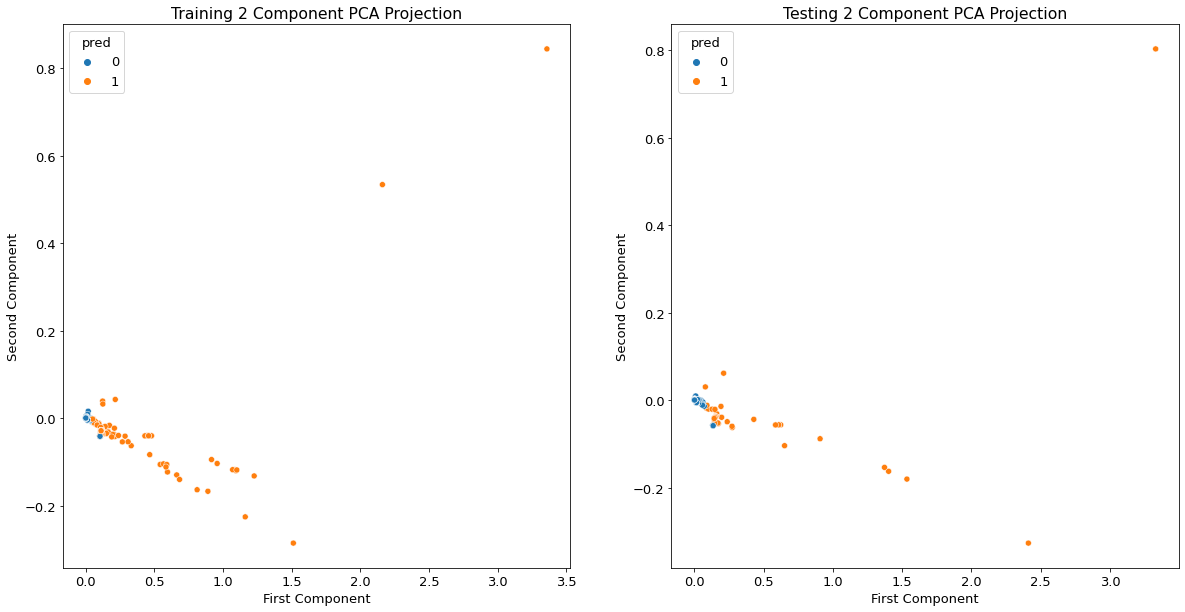

In [67]:
plotting_outlier(metalearner, X, y, 0.25, THRESHOLD, 
                 accuracy='precision', n_layers=n_layers, 
                 representation_learning_model_dict=representation_learning_model_dict, mode='stacking-decisions-filtered',
                 path=path)

1th layer of stacking
2th layer of stacking
3th layer of stacking


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


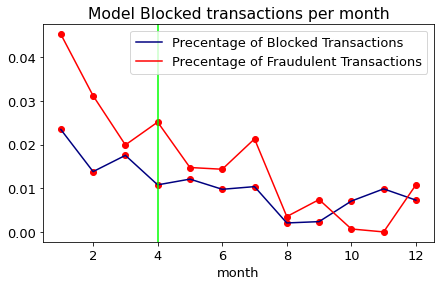

In [68]:
df_type_fraud = transcation_report(metalearner, X, y, df.month, df.channel, df.transaction_mode, 0.25, threshold=THRESHOLD, 
                                   accuracy='precision', representation_learning_model_dict=representation_learning_model_dict, 
                                   mode='stacking-decisions-filtered', n_layers=n_layers, path=path)